## Imports

In [ ]:
import functools
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

## Gridworlds

In [ ]:
#@title Implementation
class Grid(object):

  def __init__(self, discount=0.9):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0, 10, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._goal_state = (8, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(3, 3))
    plt.imshow(self._layout > -1, interpolation="nearest", cmap="YlOrRd_r")     
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(
        self._start_state[0], self._start_state[1], 
        r"$\mathbf{S}$", ha='center', va='center')
    plt.text(
        self._goal_state[0], self._goal_state[1], 
        r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-3):
      plt.plot([+0.5, w-1.5], [y+1.5, y+1.5], '-k', lw=2, alpha=0.5)
    for x in range(w-3):
      plt.plot([x+1.5, x+1.5], [+0.5, h-1.5], '-k', lw=2, alpha=0.5)

  
  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x
  
  def int_to_state(self, int_obs):
    x = int_obs % self._layout.shape[1]
    y = int_obs // self._layout.shape[1]
    return y, x

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    
    self._state = new_state
    return reward, discount, self.get_obs()
  
class AltGrid(Grid):
  
    def __init__(self, discount=0.9):
      # -1: wall
      # 0: empty, episode continues
      # other: number indicates reward, episode will terminate
      self._layout = np.array([
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0, 10,  0,  0,  0,  0,  0,  0, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
      ])
      self._start_state = (2, 2)
      self._goal_state = (2, 7)
      self._state = self._start_state
      self._number_of_states = np.prod(np.shape(self._layout))
      self._discount = discount

class FeatureGrid(Grid):
  
  def get_obs(self):
    return self.state_to_features(self._state)
  
  def state_to_features(self, state):
    y, x = state
    x /= float(self._layout.shape[1] - 1)
    y /= float(self._layout.shape[0] - 1)
    markers = np.arange(0.1, 1.0, 0.1)
    features = np.array([np.exp(-40*((x - m)**2+(y - n)**2))
                         for m in markers
                         for n in markers] + [1.])
    return features / np.sum(features**2)
  
  def int_to_features(self, int_state):
    return self.state_to_features(self.int_to_state(int_state))
  
  @property
  def number_of_features(self):
      return len(self.get_obs())

A grid world


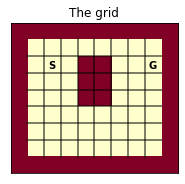


An alternative grid world


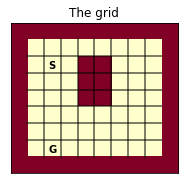


Features (visualised as 9x9 heatmaps) for different locations in the grid
(Note: includes unreachable states that coincide with walls in this visualisation.)


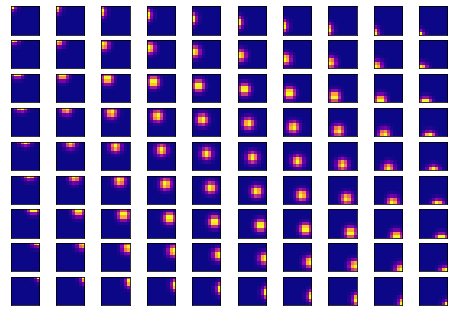

In [ ]:
#@title Show gridworlds

# Plot tabular environments
grid = Grid()
alt_grid = AltGrid()
print("A grid world")
grid.plot_grid()
plt.show()
print("\nAn alternative grid world")
alt_grid.plot_grid()
plt.show()

# Plot features of each state for non tabular version of the environment.
print(
    "\nFeatures (visualised as 9x9 heatmaps) for different locations in the grid"
    "\n(Note: includes unreachable states that coincide with walls in this visualisation.)"
)
feat_grid = FeatureGrid()
shape = feat_grid._layout.shape
f, axes = plt.subplots(shape[0], shape[1])
for state_idx, ax in enumerate(axes.flatten()):
  ax.imshow(np.reshape((feat_grid.int_to_features(state_idx)[:-1]),(9,9)),
            interpolation='nearest',
            cmap='plasma')
  ax.set_xticks([])
  ax.set_yticks([])
plt.show()

## Helpers

In [ ]:
#@title helper functions (run, but don't modify this cell)

def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward
  
map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)
  
def random_policy(q):
  return np.random.randint(4)

def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

def plot_greedy_policy(grid, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid()
  for i in range(9):
    for j in range(10):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

def plot_greedy_policy_v2(grid, pi):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(pi, axis=2)
  grid.plot_grid()
  h, w = grid._layout.shape
  for y in range(2, h-2):
    for x in range(2, w-2):
      action_name = action_names[greedy_actions[y-2, x-2]]
      plt.text(x, y, action_name, ha='center', va='center')

## 1.1: Implement Models

In [ ]:
class TabularModel(object):

  def __init__(self, number_of_states, number_of_actions):
    self.S = number_of_states
    self.A = number_of_actions
    self.model_vals = np.empty((3, self.S, self.A))


  def next_state(self, s, a):
    return self.model_vals[0, s, a]
  
  def reward(self, s, a):
    return self.model_vals[1, s, a]

  def discount(self, s, a):
    return self.model_vals[2, s, a]
  
  def transition(self, state, action):
    return (
        self.reward(state, action), 
        self.discount(state, action),
        self.next_state(state, action))
  
  def update(self, state, action, reward, discount, next_state):
    self.model_vals[:, state, action] = next_state, reward, discount
    

In [ ]:
class LinearModel(object):

  def __init__(self, number_of_features, number_of_actions):
    self.D, self.A = number_of_features, number_of_actions
    self.M = np.zeros((self.A, self.D, self.D))
    self.M_r = np.zeros((self.A, self.D))
    self.M_g = np.zeros((self.A, self.D))

  def next_state(self, s, a):
    return self.M[a] @ s
  
  def reward(self, s, a):
    return np.dot(self.M_r[a], s)

  def discount(self, s, a):
    return np.dot(self.M_g[a], s)

  def transition(self, state, action):
    return (
        self.reward(state, action),
        self.discount(state, action),
        self.next_state(state, action))

  def update(self, state, action, reward, discount, next_state, step_size=0.1):
    gradient_M = np.outer(next_state - self.next_state(state, action), state)
    self.M[action] += step_size * gradient_M

    gradient_M_r = (reward - self.reward(state, action)) * state
    self.M_r[action] += step_size * gradient_M_r

    gradient_M_g = (discount - self.discount(state, action)) * state
    self.M_g[action] += step_size * gradient_M_g


# Implement Agents

We are going to implement 4 agent:
- Tabular Q-learning with Experience Replay
- Tabular Dyna-Q with a tabular model
- Linear Q-learning with Experience Replay
- Linear Dyna-Q with a linear model



In [ ]:
 class ExperienceQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    
    self.S, self.A = number_of_states, number_of_actions
    self.replay_buffer = []
    self.Q = np.zeros((self.S, self.A))
    self.behaviour_policy = behaviour_policy
    self.n = num_offline_updates
    self.step_size = step_size

    self._state, self._action = initial_state, self.behaviour_policy(self.Q)

  @property
  def q_values(self):
    return self.Q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    exp = [s, a, r, g, next_s]
    self.replay_buffer.append(exp)

    # update q
    self.Q[s, a] += self.step_size * (r + ( g * self.Q[next_s, :].max() ) - self.Q[s, a])

    if len(self.replay_buffer) > self.n:
      samples = np.random.choice(len(self.replay_buffer), self.n)
      for i in samples:
        exp_s, exp_a, exp_r, exp_g, exp_next_s = self.replay_buffer[i]
        self.Q[exp_s, exp_a] += self.step_size * (exp_r + ( exp_g * self.Q[exp_next_s, :].max() ) - self.Q[exp_s, exp_a])

    next_a = self.behaviour_policy(self.Q)
    self._state, self._action = next_s, next_a

    return next_a
    

In [ ]:
class DynaQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    
    self.S, self.A = number_of_states, number_of_actions
    self.Q = np.zeros((self.S, self.A))
    self.replay = []
    self.behaviour_policy = behaviour_policy
    self.n = num_offline_updates
    self.step_size = step_size

    self.model = TabularModel(self.S, self.A)
    self._state, self._action = initial_state, self.behaviour_policy(self.Q)

  @property
  def q_values(self):
    return self.Q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    # record the actions we have taken as state s
    self.replay.append([s, a])
    # update q
    self.Q[s, a] += self.step_size * (r + ( g * self.Q[next_s, :].max() ) - self.Q[s, a])
    # update model
    self.model.update(s, a, r, g, next_s)

    # sample and perform offline updates
    if len(self.replay) > self.n:
      samples = np.random.choice(len(self.replay), self.n)
      for i in samples:
        sample_s, sample_a = self.replay[i]
        model_r, model_g, model_next_s = self.model.transition(*self.replay[i])
        self.Q[sample_s, sample_a] += self.step_size * (model_r + ( model_g * self.Q[int(model_next_s), :].max() ) - self.Q[sample_s, sample_a])

    next_a = self.behaviour_policy(self.Q)
    self._state, self._action = next_s, next_a 

    return next_a


In [ ]:
class LinearExperienceQ(ExperienceQ):

  def __init__(
      self, number_of_features, number_of_actions, *args, **kwargs):
    
    super(LinearExperienceQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    
    self.D = number_of_features
    self.w = np.zeros((self.D, self.A))

  def q(self, state):
    return self.w.T.dot(state).tolist()

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state

    exp = [s, a, r, g, next_s]
    self.replay_buffer.append(exp)

    gradient = ( r + ( g * self.w.T.dot(next_s).max() ) - np.vdot(self.w[:, a], s) ) * s

    self.w[:, a] += self.step_size * gradient

    if len(self.replay_buffer) > self.n:
      samples = np.random.choice(len(self.replay_buffer), self.n)
      for i in samples:
        exp_s, exp_a, exp_r, exp_g, exp_next_s = self.replay_buffer[i]
        gradient = ( exp_r + ( exp_g * self.w.T.dot(exp_next_s).max() ) - np.vdot(self.w[:, exp_a], exp_s) ) * exp_s
        self.w[:, exp_a] += self.step_size * gradient

    next_a = self.behaviour_policy(self.Q)
    self._state, self._action = next_s, next_a

    return next_a


In [ ]:
class LinearDynaQ(DynaQ):

  def __init__(self, number_of_features, number_of_actions, model_step_size=0.1,
               *args, **kwargs):
    super(LinearDynaQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    
    self.D = number_of_features
    self.w = np.zeros((self.D, self.A))

    self.model = LinearModel(self.D, self.A)

  def q(self, state):
    return self.w.T.dot(state).tolist()

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state

    self.replay.append([s, a])

    gradient = ( r + ( g * self.w.T.dot(next_s).max() ) - np.vdot(self.w[:, a], s) ) * s
    self.w[:, a] += self.step_size * gradient

    self.model.update(s, a, r, g, next_s)
    if len(self.replay) > self.n:
      samples = np.random.choice(len(self.replay), self.n)
      for i in samples:
        sample_s, sample_a = self.replay[i]
        model_r, model_g, model_next_s = self.model.transition(*self.replay[i])

        gradient = (model_r + ( model_g * self.w.T.dot(model_next_s).max()) -  np.dot(self.w[:, sample_a], sample_s)) * sample_s
        self.w[:, sample_a] += self.step_size * gradient

    next_a = self.behaviour_policy(self.Q)
    self._state, self._action = next_s, next_a

    return next_a

### Run data efficiency experiments

*Online Q-learning*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $0$

*Experience Replay*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

*DynaQ*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

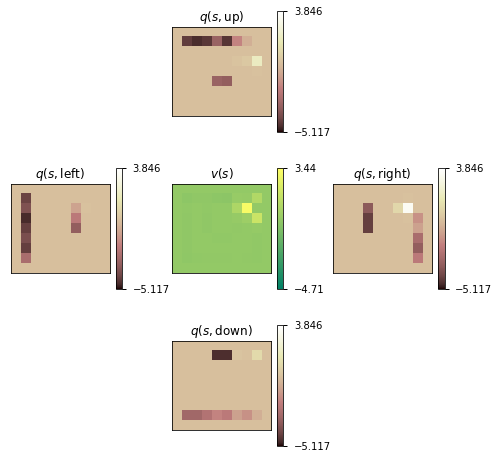

In [ ]:
# Online Q
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

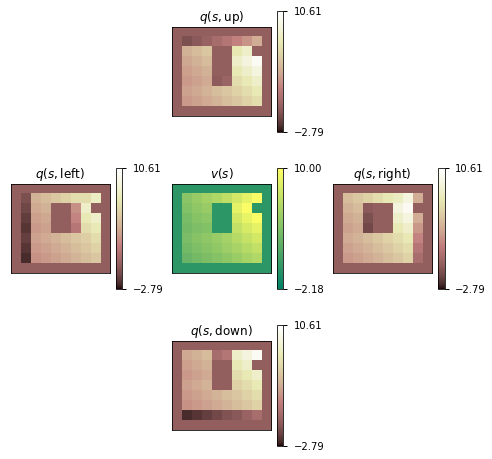

In [ ]:
# Experience Replay
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

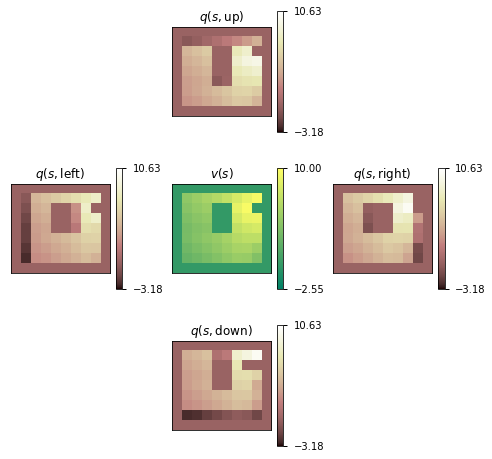

In [ ]:
# DynaQ
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

### Run experiments matching computational cost

*Online Q-learning*

* $\text{number_of_steps}$ = $62,000$ and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

*DynaQ*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

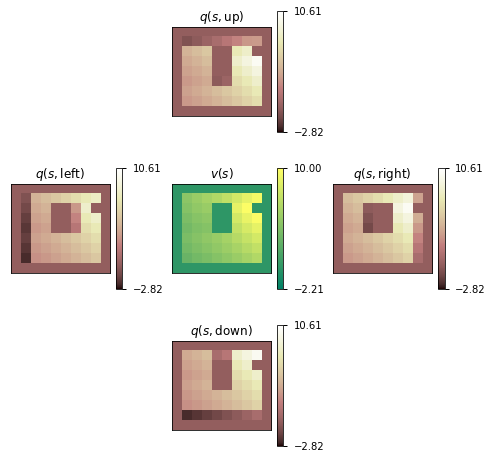

In [ ]:
# OnlineQ
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(62e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

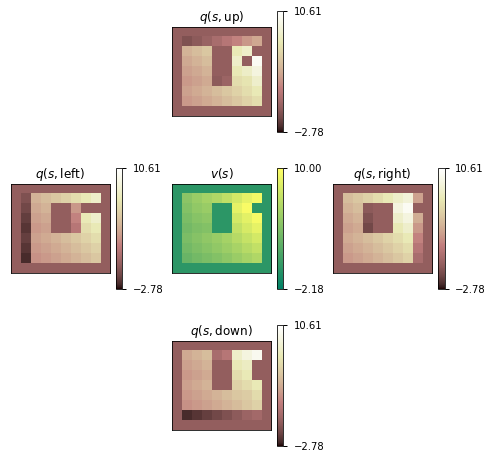

In [ ]:
# Experience Replay
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

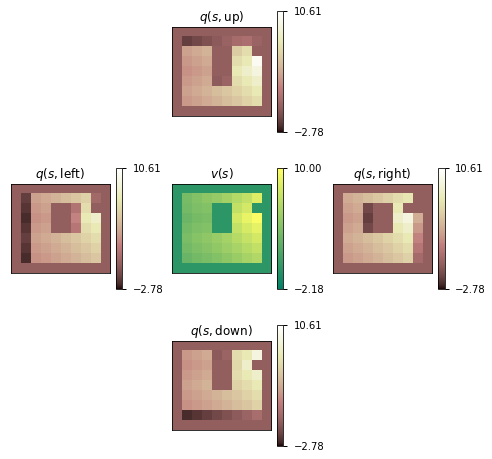

In [ ]:
# DynaQ
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

### Run experiments with linear function approximation

We will now use the $\text{FeatureGrid}$ domain, and consider the same 3 algorithms in the context of linear function approximation.

*Online Q-learning*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $10$

*DynaQ*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $10$

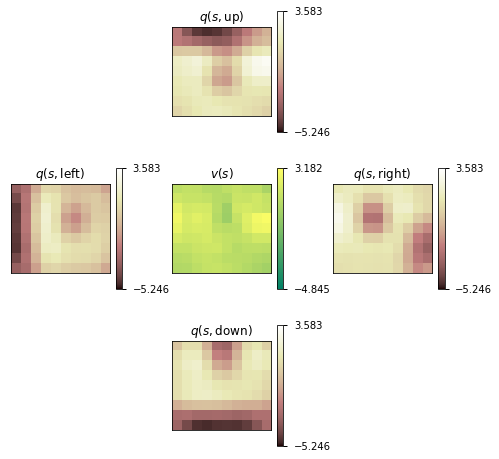

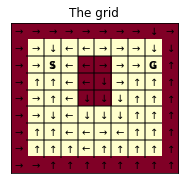

In [ ]:
# OnlineQ
grid = FeatureGrid()

agent = LinearExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=0, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

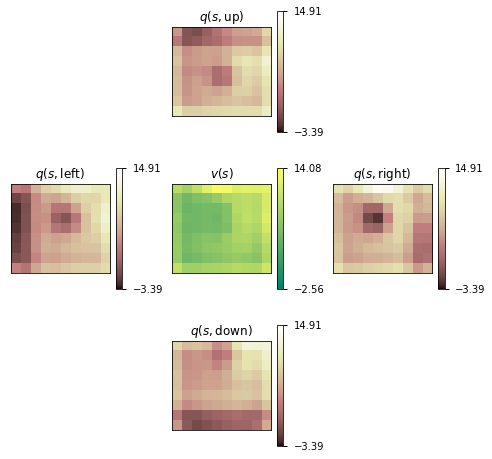

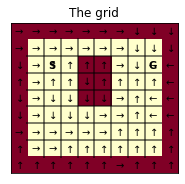

In [ ]:
# Experience Replay
grid = FeatureGrid()

agent = LinearExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=10, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

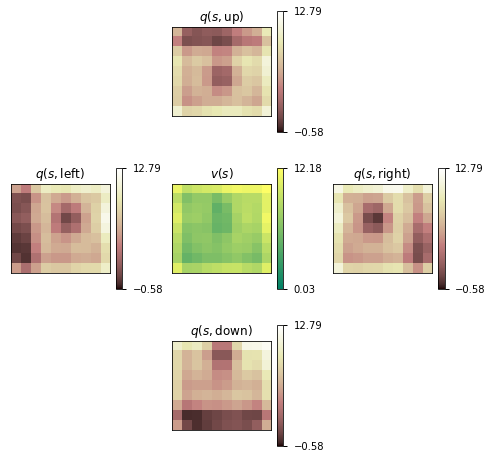

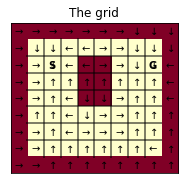

In [ ]:
# LinearDynaQ
grid = FeatureGrid()

agent = LinearDynaQ(
  number_of_features=grid.number_of_features, 
  number_of_actions=4,
  number_of_states=grid._layout.size, 
  initial_state=grid.get_obs(),
  num_offline_updates=10, 
  step_size=0.01,
  behaviour_policy=random_policy)

run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

### Run experiments in a non stationary environments

We now consider a non-stationary setting where after `pretrain_steps` in the environment, the goal is moved to a new location (from the top-right of the grid to the bottom-left - refer to "Show gridworlds"). The agent is allowed to continue training for a (shorter) amount of time in this new setting, and then we evaluate the value estimates.

*Online Q-learning*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$, and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$ and $\text{num_offline_updates}$ = $10$

*DynaQ*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$ and $\text{num_offline_updates}$ = $10$

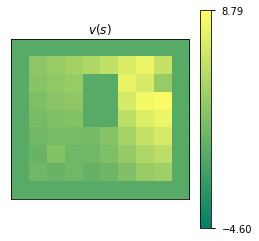

In [ ]:
# Online Q

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

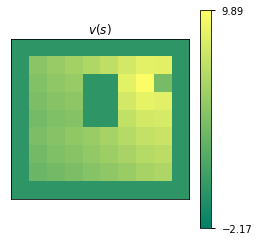

In [ ]:
# Experience Replay

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

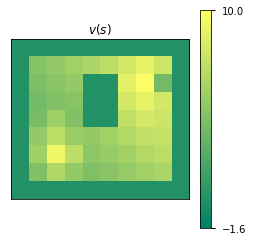

In [ ]:
# DynaQ

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)